# FORECASTING

## <font color='#1f618d'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Predictions](#3)
4. [Other ways to forecast](#4)
5. [Summary](#5)
6. [References](#References)

<a name="1"></a>
## <font color='#1f618d'> <b> 1. Introduction </font> </b>

.....................................

Forecasting means predicting the future based on past time series data.

The number of time units into the future that we want to predict is called the "forecasting horizon".

- recursive forecasting
- direct forecasting
    - all time steps at once
    - one model per time step 

In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error

# Seed for reproducibility
np.random.seed(42)


2025-06-24 18:40:24.675907: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-24 18:40:24.675973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-24 18:40:24.677792: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-24 18:40:24.685768: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-24 18:40:26.202141: W tensorflow/compiler/tf2

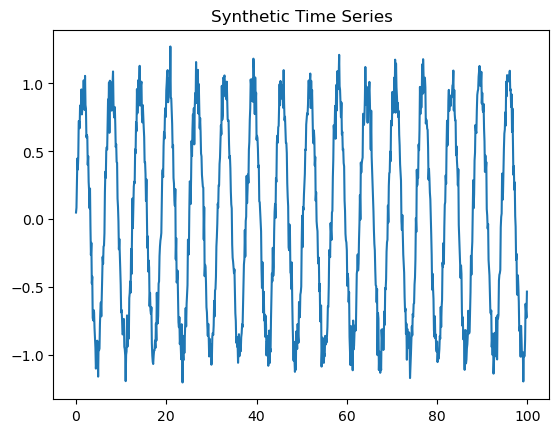

In [3]:

# 1. Generate synthetic time series (sine + noise)
time = np.arange(0, 100, 0.1)
series = np.sin(time) + 0.1 * np.random.randn(len(time))

plt.plot(time, series)
plt.title("Synthetic Time Series")
plt.show()

# 2. Create dataset with sliding windows
def create_dataset(series, window_size, horizon=1):
    X, y = [], []
    for i in range(len(series) - window_size - horizon + 1):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size:i + window_size + horizon])
    return np.array(X), np.array(y)

# Metrics

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mase(y_true, y_pred, naive):
    mae_model = mean_absolute_error(y_true, y_pred)
    mae_naive = mean_absolute_error(y_true, naive)
    return mae_model / mae_naive

## Recursive Forecasting



mi modelo predice de a uno pero quiero predecir varios pasos temporales a la vez!!!!!


For multistep forecasting with traditional machine learning models, we can use recursive or direct forecasting.

▶️ In recursive forecasting, we predict one time unit ahead, and then we use that prediction to predict the second time unit ahead, and so on, until we predict the entire horizon.

Pros:

👉 We train one machine learning model to predict the entire horizon, therefore it is more computationally efficient.

Cons:

👉 As forecasts have some error, we carry the error forward as we predict the further steps in the horizon.




We train a model to **predict one time ahead** and the we use that prediction to update the window and we generate a new pred until reach the desire number of preds.


The idea is:

- Take the initial window 
    - Which, when testing, corresponds to:
        - First "window size" values of the test set without windowing, or 
        - The first window of the test set.
- With this window, we generate a new prediction. 
- Then, we shift the window so that the last value becomes our first prediction, and we use this to predict the second value. 
- These steps are repeated until we obtain the desired number of predictions.
     - Which, when testing, is equal to the length of the validation set without windowing minus the size of the window or the length of the windowed validation set.

Our first model is trained to predict one step ahead.

<img src="images/h1.png"/>

In [58]:
# el mio
window_size = 3

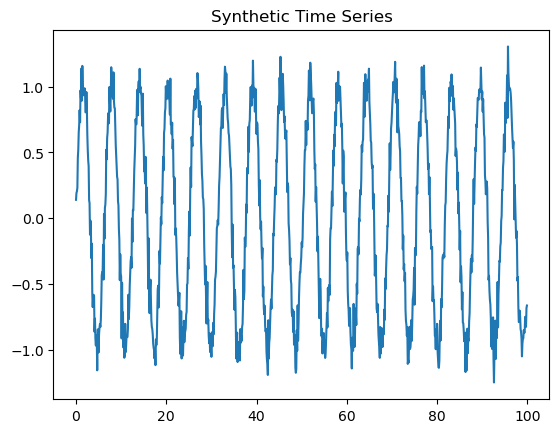

In [23]:
# 1. Generate synthetic time series (sine + noise)
time = np.arange(0, 100, 0.1)
series = np.sin(time) + 0.1 * np.random.randn(len(time))

plt.plot(time, series)
plt.title("Synthetic Time Series")
plt.show()

In [27]:
def train_val_split(time, series, time_step=800):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(time, series)

In [28]:
time_train.shape, time_valid.shape

((800,), (200,))

In [42]:
def windowed_dataset(series, 
                     window_size=3, 
                     horizon=1, 
                     batch_size=32, 
                     shuffle_buffer=10,
                     shuffle=True):
    
    # Create the dataset from the series
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Create windows of size (window_size + horizon)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    
    # Flatten the windows into batches
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Split the windows into features and labels
    ds = ds.map(lambda w: (w[:-horizon], w[-horizon:]))
    
    # Batch the dataset
    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# Apply the transformation to the training set and val set (horizon=1)
dataset_train = windowed_dataset(series_train, shuffle=True)
dataset_val = windowed_dataset(series_valid, shuffle=False)

# Apply the transformation to the training set and val set (horizon=2)
#dataset_train_2 = windowed_dataset(series_train, horizon=2, shuffle=False)
#dataset_val_2 = windowed_dataset(series_valid, horizon=2, shuffle=False)


In [43]:
for x,y in dataset_train:
    print(x.shape,y.shape)
    break

(32, 3) (32, 1)


In [44]:
def create_model(horizon=1):
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(horizon),
        tf.keras.layers.Lambda(lambda x: x*100.0)
    ]) 
    
    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["mae"])  

    return model

model = create_model()

In [45]:
# train the model
history = model.fit(dataset_train,
                    epochs=50, 
                    verbose=0,
                    validation_data=dataset_val)

In [46]:
# how many time steps to predict into the future
into_future = 4

In [47]:
def forecast(model, initial_window, num_predictions, verbose=False):
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window

    for _ in range(num_predictions):
        
        # Make a prediction based on the current window
        pred = model.predict(current_window[np.newaxis], verbose=0)
        predictions.append(pred[0][0])
        
        if verbose:
            print(f"Current window: {current_window}")
            print(f"Prediction: {pred[0][0]:.2f}")
            print("\n")

        # Update the window: remove the oldest value and add the new prediction
        current_window = np.roll(current_window, -1)  # Shift the window left
        current_window[-1] = pred[0][0]  # Add the new prediction at the end

    return np.array(predictions)

In [48]:
# agregar true value y comparar con preds

# let's generate a few predictions
initial_window = np.array([53.53772,   54.78016,   62.50613])

forecast(model, initial_window, into_future, True)

Current window: [53.53772 54.78016 62.50613]
Prediction: 0.45


Current window: [54.78016    62.50613     0.44940975]
Prediction: -7.01


Current window: [62.50613     0.44940975 -7.01322412]
Prediction: -10.82


Current window: [  0.44940975  -7.01322412 -10.82177448]
Prediction: -1.78




array([  0.44940975,  -7.013224  , -10.8217745 ,  -1.7826674 ],
      dtype=float32)

### Initial window

In [51]:
# begin of val set (not windowed)
print(series_valid[:3])

# take first window
for x, y in dataset_val.take(1):
    initial_test_window = x.numpy()[0] #x.numpy() is the first batch
    
print(initial_test_window)

series_valid[:3] == initial_test_window

[-0.80376959 -1.00600977 -1.06684829]
[-0.80376959 -1.00600977 -1.06684829]


array([ True,  True,  True])

In [52]:
### Number of preds

#len(series_valid)-G.WINDOW_SIZE-G.HORIZON+1
print(len(series_valid)-3-1+1)


# number of samples in the val set
num_samples = dataset_val.reduce(0, lambda x, batch: x + tf.shape(batch[0])[0]).numpy()
print("Total number of samples:", num_samples)

197
Total number of samples: 197


In [53]:
# PReds
#preds = forecast(model, series_valid[:G.WINDOW_SIZE], len(series_valid)-G.WINDOW_SIZE-G.HORIZON+1)

preds = forecast(model, series_valid[:3], 197)

In [54]:
preds.shape

(197,)

In [56]:
preds[0],preds[1]

(-1.0601017, -1.0488529)

### Evaluation

In [57]:
# Calculate MAE directly using the metric function
mae = tf.keras.metrics.mean_absolute_error(series_valid[3:], preds) # series_valid is NOT windowed
        # that's why we start to compare from the index equal to the window size
mae

<tf.Tensor: shape=(), dtype=float32, numpy=0.8745557>

## <font color='blue'> Direct Forecasting (multiple steps, 1 model) </font>

In [59]:
horizon = 7

dataset_train_2 = windowed_dataset(series_train, horizon=horizon, shuffle=False)
dataset_val_2 = windowed_dataset(series_valid, horizon=horizon, shuffle=False)

In [60]:
for x,y in dataset_train_2:
    print(x.shape, y.shape)
    break

(32, 3) (32, 7)


In [61]:
model2 = create_model(horizon)

In [62]:
history2 = model2.fit(dataset_train_2, 
                    epochs=50, 
                    verbose=0,
                    validation_data=dataset_val_2)

In [63]:
data = np.array([53.53772,   54.78016,   62.50613])
model2.predict(data[np.newaxis])

1/1 [==============================] - 1s 1s/step


array([[ 7.5220118,  9.661152 , 18.081438 , 12.106635 , -6.470801 ,
        -4.3837166, -8.969759 ]], dtype=float32)

In [64]:
pred = model2.predict(data[np.newaxis])
pred[0][0], pred[0][1]

1/1 [==============================] - 0s 28ms/step


(7.5220118, 9.661152)

In [65]:
pred.shape

(1, 7)

## Evaluation


In [66]:
loss, mae = model2.evaluate(dataset_val_2)


6/6 [==============================] - 0s 7ms/step - loss: 0.0764 - mae: 0.2164


In [67]:
#Use Option 1 if you want full control (e.g., plot vs. true values, compute per-step errors, etc.).

# Extract true targets from dataset_val_2
y_true = []
y_pred = []

for x, y in dataset_val_2:
    preds = model2.predict(x, verbose=0)
    y_pred.append(preds)
    y_true.append(y.numpy())

# Concatenate all predictions and true values
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Evaluate
mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred).numpy()


In [69]:
mae.shape # (n_samples,)

(191,)

In [71]:
mae_agg = tf.reduce_mean(tf.keras.metrics.mean_absolute_error(y_true, y_pred)).numpy() #This gives you a scalar MAE over all 7-step predictions 
                        #— suitable for model comparison.
mae_agg

0.21644524

Yes, this is a valid and standard approach for direct forecasting evaluation, because:

You're evaluating how well the model would do when it has the actual input data (e.g., when deployed and sliding through a real stream).

You never use future values as inputs — the input window contains only known past values.

The future values (y_true) are used only for evaluation, not prediction.

So yes — it's valid for comparing models as long as you're using the same setup for all.

❌ Don't use future values as inputs, but using them as targets for evaluation is correct.

✅ 1. Sliding window in validation (using t1, t2, t3 after using t0, t1, t2)
You're right:

If you use windowed_dataset(...) to slide the window by 1 step, you'll have:

input: [t0, t1, t2] → predict [t3, ..., t9]

input: [t1, t2, t3] → predict [t4, ..., t10] ← here you're using t3, which was in the target of the previous window.

👉 This is not an issue during validation because you already have the full series_valid — i.e., you're not doing forecasting, you're simulating it.

But you're right: this means:

In production, I can’t use the second input window unless I already know t3.

So...

✅ 2. In production I must use real future data for each new prediction window
Exactly. In direct forecasting, you need true recent values for each prediction window.

So in production:

You'd wait for new data to come in before making the next 7-step prediction.

Or retrain/update as new observations arrive.

You don't recursively use your predictions as inputs (that would be recursive forecasting, a different setup).

✅ 3. In validation I trust the future values as ground truth
Exactly:

You assume series_valid is the truth.

You simulate how the model would behave if it were fed real data at every step.

That makes model comparison fair — as long as all models are evaluated in the same way.

🔁 Summary

| Context        | Input values come from      | Can you use sliding windows?          | Are repeated predictions OK?       |
|----------------|-----------------------------|----------------------------------------|-------------------------------------|
| **Validation** | Real data (`series_valid`)  | ✅ Yes — simulation with true inputs   | ✅ Yes — allows model comparison    |
| **Production** | Latest observed real data   | ❌ No — only when new data arrives     | ❌ No — must wait for real data     |


## <font color='blue'> Direct Forecasting (multiple models) </font>

In [73]:
horizon = 3

dataset_train_3 = windowed_dataset(series_train, horizon=horizon, shuffle=False)
dataset_val_3 = windowed_dataset(series_valid, horizon=horizon, shuffle=False)

In [74]:
"""
horizon = 3  # 3 steps ahead
window_size = 3

# 1. Prepare full multi-step dataset (horizon=3)
full_dataset_train = windowed_dataset(
    series_train,
    window_size=window_size,
    horizon=horizon,
    batch_size=32,
    shuffle=True
)

full_dataset_val = windowed_dataset(
    series_valid,
    window_size=window_size,
    horizon=horizon,
    batch_size=32,
    shuffle=False
)

# 2. Helper function to extract single-step target dataset
def dataset_for_step(full_ds, step=0):
    # step=0 for 1-step ahead, step=1 for 2-step ahead, etc.
    return full_ds.map(lambda x, y: (x, y[:, step:step+1]))

# 3. Prepare datasets for each step
datasets_train = [dataset_for_step(full_dataset_train, step=i) for i in range(horizon)]
datasets_val = [dataset_for_step(full_dataset_val, step=i) for i in range(horizon)]

# 4. Train models for each horizon step
models = []
histories = []

for step in range(horizon):
    print(f"Training model for step {step + 1} ahead prediction")
    model = create_model(horizon=1)
    history = model.fit(
        datasets_train[step],
        epochs=50,
        verbose=0,
        validation_data=datasets_val[step]
    )
    models.append(model)
    histories.append(history)
"""

'\nhorizon = 3  # 3 steps ahead\nwindow_size = 3\n\n# 1. Prepare full multi-step dataset (horizon=3)\nfull_dataset_train = windowed_dataset(\n    series_train,\n    window_size=window_size,\n    horizon=horizon,\n    batch_size=32,\n    shuffle=True\n)\n\nfull_dataset_val = windowed_dataset(\n    series_valid,\n    window_size=window_size,\n    horizon=horizon,\n    batch_size=32,\n    shuffle=False\n)\n\n# 2. Helper function to extract single-step target dataset\ndef dataset_for_step(full_ds, step=0):\n    # step=0 for 1-step ahead, step=1 for 2-step ahead, etc.\n    return full_ds.map(lambda x, y: (x, y[:, step:step+1]))\n\n# 3. Prepare datasets for each step\ndatasets_train = [dataset_for_step(full_dataset_train, step=i) for i in range(horizon)]\ndatasets_val = [dataset_for_step(full_dataset_val, step=i) for i in range(horizon)]\n\n# 4. Train models for each horizon step\nmodels = []\nhistories = []\n\nfor step in range(horizon):\n    print(f"Training model for step {step + 1} ahead

In [75]:
horizon = 3  # 3 steps ahead
window_size = 3

# 1. Prepare full multi-step dataset (horizon=3)
full_dataset_train = windowed_dataset(
    series_train,
    window_size=window_size,
    horizon=horizon,
    batch_size=32,
    shuffle=True
)

full_dataset_val = windowed_dataset(
    series_valid,
    window_size=window_size,
    horizon=horizon,
    batch_size=32,
    shuffle=False
)

In [76]:
# 2. Helper function to extract single-step target dataset
def dataset_for_step(full_ds, step=0):
    # step=0 for 1-step ahead, step=1 for 2-step ahead, etc.
    return full_ds.map(lambda x, y: (x, y[:, step:step+1]))

# 3. Prepare datasets for each step
datasets_train = [dataset_for_step(full_dataset_train, step=i) for i in range(horizon)]
datasets_val = [dataset_for_step(full_dataset_val, step=i) for i in range(horizon)]

In [77]:
datasets_train

[<_MapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>]

In [78]:
len(datasets_train)

3

In [79]:
# 4. Train models for each horizon step
models = []
histories = []

for step in range(horizon):
    print(f"Training model for step {step + 1} ahead prediction")
    model = create_model(horizon=1)
    history = model.fit(
        datasets_train[step],
        epochs=50,
        verbose=0,
        validation_data=datasets_val[step]
    )
    models.append(model)
    histories.append(history)

Training model for step 1 ahead prediction
Training model for step 2 ahead prediction
Training model for step 3 ahead prediction


Explanation:
You create one dataset with all 3 future steps as targets.

Then split it into 3 datasets, each with targets for a single step.

Train 3 separate models, one per step, each predicting just 1 step ahead.

Validation datasets are similarly split.

This matches your current style and is great for learning.

In [80]:
# 1. Select the last window from validation data
input_window = series_valid[-window_size:]  # shape: (3,)

# 2. Expand dims to match model input shape: (1, window_size)
input_window = input_window[np.newaxis, :]

# 3. Predict using each model
predictions = []
for i, model in enumerate(models):
    pred = model.predict(input_window, verbose=0)
    predictions.append(pred[0, 0])  # extract scalar

# 4. Combine into a numpy array
predictions = np.array(predictions)
print("3-step ahead forecast:", predictions)


3-step ahead forecast: [-0.6422824 -0.574968  -0.6000123]


Each value corresponds to:

Step 1 ahead (t+1)

Step 2 ahead (t+2)

Step 3 ahead (t+3)

all models use the same input window.

That’s the key idea behind this approach (sometimes called multi-output via multiple models):

Each model is trained to predict a specific step ahead (e.g., +1, +2, +3).

But they all take the same type of input: the most recent window_size values (e.g., [t0, t1, t2]).

So at inference time, you can pass the same input window to all models and get different horizon predictions.

This approach is coherent, simple, and helps you learn how horizon affects prediction quality.

all models use the same input window.

That’s the key idea behind this approach (sometimes called multi-output via multiple models):

Each model is trained to predict a specific step ahead (e.g., +1, +2, +3).

But they all take the same type of input: the most recent window_size values (e.g., [t0, t1, t2]).

So at inference time, you can pass the same input window to all models and get different horizon predictions.

This approach is coherent, simple, and helps you learn how horizon affects prediction quality.

Yes — exactly like before, you use series_valid as the source of real inputs and true targets for evaluation.

Let me walk you through the evaluation clearly.

✅ What we assume during evaluation
Even though in production you wouldn't know future values, during evaluation we simulate a scenario where:

You have full access to series_valid.

You slide a window across it, and for each window, you predict 1, 2, or 3 steps ahead using the corresponding model.

You compare each prediction with the actual future value from series_valid.

So yes, you use series_valid as "real inputs" to create windows and as ground truth to compare against.

In [82]:
for i in range(3):
    loss, mae = models[i].evaluate(datasets_val[i])


7/7 [==============================] - 0s 6ms/step - loss: 0.0529 - mae: 0.1858


In [ ]:
# with more control!!!

In [81]:
window_size = 3
horizon = 3

X = []
y_true_steps = [[] for _ in range(horizon)]  # one list for each horizon step

# Slide a window over series_valid
for i in range(len(series_valid) - window_size - horizon + 1):
    window = series_valid[i : i + window_size]
    X.append(window)
    for step in range(horizon):
        y_true_steps[step].append(series_valid[i + window_size + step])

X = np.array(X)  # shape: (num_samples, window_size)
y_true_steps = [np.array(step) for step in y_true_steps]  # list of (num_samples,) arrays

# Predict with each model
y_preds = []
for step in range(horizon):
    preds = models[step].predict(X, verbose=0)
    y_preds.append(preds[:, 0])  # flatten to (num_samples,)

# Compute MAE for each step
for step in range(horizon):
    mae = tf.keras.metrics.mean_absolute_error(y_true_steps[step], y_preds[step]).numpy()
    print(f"Step {step+1} ahead MAE: {mae:.4f}")


Step 1 ahead MAE: 0.1163
Step 2 ahead MAE: 0.1431
Step 3 ahead MAE: 0.1858


As expected, the MAE usually increases with the step due to increasing uncertainty.

✅ If your goal is model selection or summarizing performance, then:
Yes, aggregating MAEs makes sense — but you need to be careful how:

Option 1: Mean of MAEs (simple average)
python
Copiar
Editar
mean_mae = np.mean([mae_step1, mae_step2, mae_step3])
Interpretable, easy.

Assumes all steps are equally important.

✅ Good for general-purpose comparison.

Option 2: Weighted MAE (e.g., giving more weight to closer predictions)
python
Copiar
Editar
weights = [0.5, 0.3, 0.2]  # must sum to 1
weighted_mae = np.average([mae1, mae2, mae3], weights=weights)
Reflects real-world priority if step-1 is more important than step-3.

✅ Better for business-aware evaluation.

❌ If your goal is scientific evaluation or debugging, don’t aggregate
Instead:

Report MAE per horizon — that shows how error grows.

Plot MAE vs. step — very informative.

✅ Summary
Goal	Aggregate MAEs?	Method
Compare models	✅ Yes	Mean or weighted average
Debug / analyze forecast	❌ No	Report step-by-step MAE
Business metric (e.g., 3-day sales forecast)	✅ Yes (but weighted!)	Business-aware weighting

Let me know your context and I can suggest the best aggregation method.

In both Direct Forecasting and Multi-Output Forecasting, the general rule during live prediction or walk-forward validation is to always use observed, actual values to update your input window, not the model's own prior predictions. This is a defining characteristic that differentiates them from recursive forecasting.

no es tanto un problema, en muchos cases, x.ej. el clima puedo actualizar fácilmente con datos nuevos

en la ev. del modelo me miento si; pero la idea es comparar modelos


---
en recursive forecasting (debo comprar usando recursive o no?????)






Exactly — comparing a 1-step ahead model with a multi-step direct model without accounting for their different forecasting strategies isn’t really fair.

Here’s why:

1-step ahead models require rolling (recursive) forecasting:
You predict one step, then feed that prediction back in to predict the next step, and so on. Errors can accumulate.

Multi-step direct models predict all future steps at once, without recursion, but rely on having the latest true inputs for each forecast window.

Because of these differences:

Their error characteristics differ (error accumulation vs. one-shot error).

Evaluation methods must reflect the forecasting approach (rolling forecast for 1-step, direct forecast evaluation for multi-step).

So when comparing them, you should:
Evaluate the 1-step model using recursive forecasting to produce multi-step predictions.

Evaluate the multi-step model using direct forecasting.

Compare their final multi-step prediction errors fairly.

Only then you get a meaningful comparison.

## Comapriosn

quick recap; in recursive forecasting, despise i have access to full series_valid i cant use them as inputs to the rolling windows, but that is ok for multi-step pred and direct forecasting; thats make sense in part because what is really matters to me is taht to predict until some "forecasting horizon" for example 10 depsise the length of my val ds be for ex 1000


🔁 Recursive Forecasting
You train one model to predict 1-step ahead.

During evaluation or production:

You only use the predicted values to roll the input window forward.

Even if you have series_valid, you don't peek — otherwise you're cheating.

This simulates a real scenario where only past predicted values are available.

✅ Makes sense when your goal is to simulate forecasting into the future, step-by-step, for a fixed horizon (e.g., 10 steps), regardless of total validation length.

🎯 Direct Forecasting (Multi-step)
You train one model to predict multiple steps at once (e.g., next 3, next 10).

During evaluation:

You can use full series_valid to slide input windows.

Each window gives a full multi-step prediction.

Reusing real data for overlapping inputs is OK and standard.>>>>>>>>>>>>>>-------------

✅ Makes sense when you're doing one-shot forecasts, and what matters is how accurate your N-step predictions are — e.g., daily weather, 7-day energy demand, etc.

🔍 What really matters:
Your forecasting goal (e.g., predict next 10 steps) determines:

How you prepare inputs,

Whether you simulate recursive prediction,

How you evaluate models (rolling or direct),

Whether you're okay using series_valid inputs repeatedly.

So yes — your understanding is solid. You’re thinking like a time series practitioner now.

in direct forecasting im assuming series valid is "real data" and in recursive i have to be aware that, if i calculate metrics for the entire val set maybe some "worse" model can achieve better results if it propagates errors less? 


📌 Direct Forecasting
You use real data from series_valid as input for every forecast window.

You assume access to ground truth at every time step — you're simulating repeated 1-shot predictions.

✅ This is coherent because each prediction is independent of the previous one.

🔁 Recursive Forecasting
You generate predictions step-by-step, feeding each prediction back in as input for the next.

So:

The first steps use real data.

Later steps use your own previous predictions, so errors accumulate.

Even if a model has a lower per-step error, it might:

❌ Accumulate errors faster.

✅ Or propagate them more gracefully (even if it's slightly worse per step).

🤔 Implication for Evaluation:
In recursive forecasting, when you evaluate over the full validation set, what really matters is how the model behaves under error propagation, not just per-step accuracy.

So yes:

A "worse" model (higher per-step MAE) can outperform a “better” one in multi-step recursive forecasts if it’s more stable and propagates less error.

That’s why it's critical to evaluate full forecast sequences, not just 1-step metrics, in recursive setups.

| Forecasting Type | Inputs during eval      | Model comparison fair if…                                           |
| ---------------- | ----------------------- | ------------------------------------------------------------------- |
| **Direct**       | Real validation windows | All models use same ground truth inputs                             |
| **Recursive**    | Rolling predictions     | You compare based on **forecast trajectory**, not per-step MAE only |


📦 Retail Demand Forecasting (Daily Products in a Supermarket)
🎯 Goal:
Forecast the next 7 days of product demand (e.g., bread, milk, etc.) to optimize inventory and avoid stockouts or overstock.

🔁 Forecasting cycle:
Every Monday, you:

Collect the most recent 30 days of sales data.

Use a model to predict demand for Tuesday–Sunday (a 7-day horizon).

You send the prediction to the supply chain team.

During the week, real sales happen. You now know the true demand for those 7 days.

The following Monday:

You append those 7 new days to your dataset.

You slide the window forward and generate a new 7-day forecast.

Optionally: you retrain or fine-tune the model if enough new data has accumulated.

🔍 Why Direct Forecasting is a good fit:
You need all 7 future values at once, not one-by-one.

You have clear, regular update cycles (weekly).

You can use the most recent real data each time.

You care more about stable, horizon-wide accuracy than step-by-step rolling.

⚙️ Optional retraining?
Yes — you might choose to:

Retrain monthly or quarterly, depending on data drift (e.g., seasonality, promotions).

Use online learning or transfer learning if you want to adapt quickly.

| Aspect          | Description                                        |
| --------------- | -------------------------------------------------- |
| Use case        | Retail weekly demand forecast                      |
| Horizon         | 7 days                                             |
| Input data      | Last 30 days of **real** demand                    |
| Forecast cycle  | Weekly                                             |
| Update strategy | New data replaces old window, retrain periodically |
| Model type      | Direct, one-shot prediction for 7 steps            |



In [85]:
#https://chatgpt.com/c/685b25d5-34dc-800e-89ce-f496fca35352

⚡ Electricity Load Forecasting — Real-Time Grid Control
🎯 Goal:
Predict the next 60 minutes of electricity demand minute-by-minute, using current and past load data to support real-time grid balancing.

🔁 Forecasting flow:
Every minute, the grid operator:

Receives a new data point: the current electricity demand.

Feeds the last N minutes (e.g., 30) of load into a model.

Predicts 1 step ahead (demand at t+1).

The predicted value is used in:

Real-time control decisions (e.g., turn on/off generators, balance loads).

Also fed back as input to predict demand at t+2, then t+3, ..., until t+60.

This process creates a rolling forecast:
Predict → append → predict again → repeat...

🔍 Why Recursive Forecasting is a good fit:
You only know current/past values — no real future data to use.

The prediction must be made step-by-step into the future.

You want a lightweight model (train one model for 1-step).

Real-time updating makes retraining less practical every few minutes.

⚙️ Evaluation
During validation, you must simulate recursive prediction, feeding your own model outputs back in, to get a realistic error profile.

| Aspect           | Description                                   |
| ---------------- | --------------------------------------------- |
| Use case         | Electricity demand, minute-by-minute          |
| Horizon          | 60 steps (60 minutes)                         |
| Input            | Only past real values + recursive predictions |
| Forecast cycle   | Continuous, real-time                         |
| Model type       | 1-step model, used recursively                |
| Evaluation style | Rolling forecast with prediction feedback     |


Recursive forecasting makes most sense when:

You don’t have access to future data before making predictions.

You want to forecast many steps ahead, but don't want to train multiple models.

Forecasting is part of a live, streaming or control system.